In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
#import transformers
# nltk.download('punkt')
# nltk.download('stopwords')
stop = stopwords.words('english')
import re
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, tree
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
all_wines = pd.read_csv('Data/winemag-data-130k-v2.csv')
all_wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
clean_wines = all_wines.drop(columns=['Unnamed: 0', 'taster_twitter_handle', 'region_2'])
clean_wines = clean_wines.dropna()
clean_wines.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [4]:
clean_wines['variety'] = clean_wines['variety'].replace(['Weissburgunder'], 'Chardonnay')
clean_wines['variety'] = clean_wines['variety'].replace(['Spatburgunder'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Grauburgunder'], 'Pinot Gris')
clean_wines['variety'] = clean_wines['variety'].replace(['Garnacha'], 'Grenache')
clean_wines['variety'] = clean_wines['variety'].replace(['Pinot Nero'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Alvarinho'], 'Albarino')

In [5]:
clean_wines['vintage'] = clean_wines['title'].str.extract('(\d\d\d\d)', expand=True)
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013


In [6]:
clean_wines['type'] = ['white' if x in ['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Sparkling Blend', 'Pinot Gris',
                                        'Champagne Blend', 'GrÃ¼ner Veltliner', 'Pinot Grigio', 'Portuguese White', 'Viognier',
                                        'GewÃ¼rztraminer', 'GewÃ¼rztraminer'] else 'red' for x in clean_wines['variety']]
clean_wines


,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red


In [7]:
clean_wines['word_count'] = clean_wines['description'].str.lower().str.split().str.len()
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43


In [8]:
clean_wines = clean_wines[clean_wines['vintage'].notna()]
clean_wines = clean_wines.copy()
clean_wines['vintage'] = clean_wines['vintage'].astype(int)
clean_wines['age'] = 2020 - clean_wines['vintage'] 
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7


In [9]:
clean_wines = clean_wines.drop_duplicates('description')
clean_wines = clean_wines[pd.notnull(clean_wines.price)]

In [10]:
clean_wines['winery_count'] = clean_wines['winery'].value_counts()
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,winery_count
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7,NaN
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8,NaN
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9,NaN
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7,NaN
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,NaN
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,NaN
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,NaN
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,NaN


In [11]:
clean_wines.quantile(q=0.75, axis=0, numeric_only=True)

points            91.0
price             49.0
vintage         2014.0
word_count        49.0
age               10.0
winery_count       NaN
Name: 0.75, dtype: float64

In [12]:
clean_wines['good_meh'] = clean_wines['points'].apply(lambda x: 'good' if x >= 91 else 'meh')
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,winery_count,good_meh
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7,NaN,meh
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8,NaN,meh
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9,NaN,meh
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7,NaN,meh
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8,NaN,meh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,NaN,meh
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,NaN,meh
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,NaN,meh
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,NaN,meh


In [13]:
good_wines = clean_wines[clean_wines['good_meh'] == 'good']
good_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,winery_count,good_meh
123,Australia,The blend is roughly two-thirds Shiraz and one...,Parson's Flat,92,40.0,South Australia,Padthaway,Joe Czerwinski,Henry's Drive Vignerons 2006 Parson's Flat Shi...,Shiraz-Cabernet Sauvignon,Henry's Drive Vignerons,2006,red,36,14,NaN,good
144,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Virginie Boone,Terra Valentine 2013 K Block Cabernet Sauvigno...,Cabernet Sauvignon,Terra Valentine,2013,red,37,7,NaN,good
145,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Matt Kettmann,Testarossa 2013 Guidotti Vineyard Pinot Noir (...,Pinot Noir,Testarossa,2013,red,43,7,NaN,good
146,US,"There's a touch of hot asphalt, pencil lead an...",Family Reserve,91,68.0,California,Santa Ynez Valley,Matt Kettmann,Vincent Vineyards 2010 Family Reserve Cabernet...,Cabernet Sauvignon,Vincent Vineyards,2010,red,51,10,NaN,good
147,US,"Black cherry, black plum and black currant are...",Family Reserve,91,68.0,California,Santa Ynez Valley,Matt Kettmann,Vincent Vineyards 2012 Family Reserve Cabernet...,Cabernet Sauvignon,Vincent Vineyards,2012,red,55,8,NaN,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129928,Spain,This represents Torres' highest effort in Prio...,Salmos Perpetual,91,52.0,Catalonia,Priorat,Michael Schachner,Torres 2005 Salmos Perpetual Red (Priorat),Red Blend,Torres,2005,red,47,15,NaN,good
129930,Spain,"Arguably on the heavy and rich side, but if yo...",Crianza,91,26.0,Northern Spain,Ribera del Duero,Michael Schachner,Costaval 2005 Crianza (Ribera del Duero),Tempranillo Blend,Costaval,2005,red,48,15,NaN,good
129932,Argentina,Andeluna's top wines tend to be ripe and plump...,Pasionado,91,55.0,Mendoza Province,Uco Valley,Michael Schachner,Andeluna 2004 Pasionado Red (Uco Valley),Red Blend,Andeluna,2004,red,61,16,NaN,good
129936,France,A blend from several premier cru vineyards in ...,Premier Cru,91,66.0,Burgundy,Pommard,Roger Voss,Bouchard Père & Fils 2005 Premier Cru (Pommard),Pinot Noir,Bouchard Père & Fils,2005,red,61,15,NaN,good


In [14]:
clean_wines['char_count'] = clean_wines["description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
clean_wines['sentence_count'] = clean_wines["description"].apply(lambda x: len(str(x).split(".")))
clean_wines['avg_word_length'] = clean_wines['char_count'] / clean_wines['word_count']
clean_wines['avg_sentence_lenght'] = clean_wines['word_count'] / clean_wines['sentence_count']
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,vintage,type,word_count,age,winery_count,good_meh,char_count,sentence_count,avg_word_length,avg_sentence_lenght
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,...,2013,white,33,7,NaN,meh,167,3,5.060606,11.000000
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,...,2012,red,41,8,NaN,meh,209,3,5.097561,13.666667
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,...,2011,red,42,9,NaN,meh,220,4,5.238095,10.500000
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,...,2013,red,31,7,NaN,meh,151,3,4.870968,10.333333
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,...,2012,white,30,8,NaN,meh,131,4,4.366667,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,...,2010,white,52,10,NaN,meh,237,5,4.557692,10.400000
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,...,2012,red,37,8,NaN,meh,184,4,4.972973,9.250000
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,...,2013,white,32,7,NaN,meh,180,3,5.625000,10.666667
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,...,2013,red,43,7,NaN,meh,183,4,4.255814,10.750000


In [22]:
clean_wines.to_csv('Data/wines_with_description_features.csv')

In [15]:
features = clean_wines[['price', 'age', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 
                        'avg_sentence_lenght']]
features

,price,age,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
3,13.0,7,33,167,3,5.060606,11.000000
4,65.0,8,41,209,3,5.097561,13.666667
5,15.0,9,42,220,4,5.238095,10.500000
6,16.0,7,31,151,3,4.870968,10.333333
9,27.0,8,30,131,4,4.366667,7.500000
...,...,...,...,...,...,...,...
129959,57.0,10,52,237,5,4.557692,10.400000
129962,40.0,8,37,184,4,4.972973,9.250000
129965,28.0,7,32,180,3,5.625000,10.666667
129968,30.0,7,43,183,4,4.255814,10.750000


In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, clean_wines['good_meh'], random_state=42)

In [17]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7144917698964873

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7755811980315629

In [19]:
sorted(zip(rf.feature_importances_, features), reverse=True)

[(0.31905870388821966, 'price'),
 (0.21347841121293937, 'char_count'),
 (0.14883536314941562, 'avg_word_length'),
 (0.10569361560795859, 'age'),
 (0.1056258063758258, 'word_count'),
 (0.07440266811323933, 'avg_sentence_lenght'),
 (0.032905431652401625, 'sentence_count')]

In [20]:
clean_wines.to_csv('Data/full_wine_data.csv',index=False)

<AxesSubplot:>

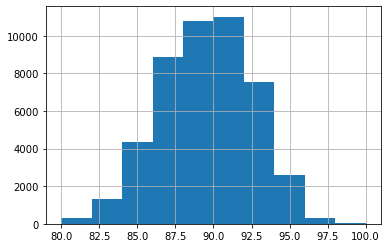

In [21]:
clean_wines['points'].hist()